# ```FACE MASK DETECTION```

## Table of contents

0. [Face Recognition at the gate](#recogface)
0. [Number Plate Recognition](#numplaterecog)
1. [All the imports](#import)
2. [Send An Email to the Coordinator](#email)
3. [preprocess large amount of images in a folder](#preprocess)
4. [Split the data into train and test](#split)
5. [Confusion Matrix Score](#cms)

6. Models
   - [Support Vector Classifier](#sv)
   - [Decision Tree Classifier](#dt)
   - [Random Forest Classifier](#rf)
   - [Naive Bayes Classifier](#nb)
   - [Logistic regression Classifier](#lr)
   - [K-Nearest Neighbors](#knn)

7. [Load From DIsk](#loadfromdisk)  
8. [Webcam](#webcam)


### <a id="import" ></a> All the imports


In [1]:
import numpy as np, cv2, os, yagmail
import matplotlib.pyplot as plt, seaborn as sns
import face_recognition
from datetime import datetime, timedelta
from scipy.spatial import distance
import pytesseract, imutils
import csv

from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# let:
join = os.path.join
listdir = os.listdir
scale=(100,100)

### <a id="email" ></a> Send an Email


In [2]:
#!pip3 install yagmail[all]

sender_password     = input("Type in your password here")

In [3]:
def date_and_time():        # This *datetime.now()* is necessary to get the current updated time
    now = datetime.now()
    date = now.strftime("%Y-%m-%d")  # Month is small m
    time = now.strftime('%H:%M:%S')  # Minute is capital M
    return  date, time

In [39]:

#saves the image as NotWearingMaskAlert.jpg in the AI LAB Workplace Monitoring directory.  
save_img_location = r".\AI LAB Workplace Monitoring\NotWearingMaskAlert.jpg"

sender_mail_addr = "youremail@gmail.com"
receiver_mail_addr = ["youremail@gmail.com"] #can be a list of emails...
subject = "Worker not wearing a mask; Date {}, Time: {}"
contents = "There is high probability that a worker is not wearing a mask. Take action!"

def sendEmailWithAttachment(frame,
                        save_img_location   =   save_img_location, 
                        sender_mail_addr    =   sender_mail_addr, 
                        sender_password     =   sender_password,
                        receiver_mail_addr  =   receiver_mail_addr,
                        subject             =   subject,
                        contents            =   contents
                                ):

        cv2.imwrite(save_img_location, frame)
        sent = False
        try:
                yag = yagmail.SMTP(sender_mail_addr, sender_password)

                yag.send(to= receiver_mail_addr,         
                        subject = subject,
                        contents = contents,
                        attachments=[save_img_location]
                        )
                print(f"\nEmail sent successfuly Date: {date} Time: {time}\n")
                sent = True
        except Exception as e: 
                print(f"\nError in sending the mail. Here is the error message: \n\n{e} ")
                
        return sent


frame = cv2.imread(r".\AI LAB Workplace Monitoring\Workers Photos Use During Entry At Gate\train\biden\biden2.jpg")

date, time = date_and_time()
sendEmailWithAttachment( frame, 
                        subject= subject.format(date, time),
                        sender_password=sender_password, 
                        receiver_mail_addr=receiver_mail_addr
                        )


Email sent successfuly Date: 2022-06-20 Time: 10:37:10



True

### <a id="recogface" ></a> Face Recognition at the gate

In [5]:
imagesFolder =  r".\AI LAB Workplace Monitoring\Workers Photos Use During Entry At Gate\test"
csv_file = r".\AI LAB Workplace Monitoring\Register_01.csv"
    

In [6]:

# Work start at 8:00 and end at 18:00. But a worker can be registered if he comes even early, from 7:00
# If a worker arrives untill at 8:30, he's not late according to the company's rules. 
# Elif he arrives from 8:30 to 10, he is late and a warning is sent. 
# Else, he is not registered and thus won't be paid the wage for that particular day.

def markAttendance(name, csv_file):
    
    late = False
    now = datetime.now()  
    register_hr = ( now.hour >= 7 and now.hour <= 10 )
    
    if register_hr:
        with open(csv_file, 'r+') as f:  #both read and write
            register = f.readlines()

            nameList = []
            
            # nameList =[ [line.split(',')[0], line.split(',')[1] ] for line in register if not line in [',,\n', '\n'] ]
            for line in register:
                if not line in [',,\n', '\n']:
                    entry = line.split(',')
                    nameList.append([entry[0], entry[1]])
                    
            date, time = date_and_time()
            if [name, date] not in nameList and register_hr:
                f.writelines(f"\n{name},{date},{time}")
                print(f"{name} registered successfuly at {time}")
                
                # If the worker is late (comes after 08:30), send a warning to the Director
                # But if a worker arrives after 10:00, he is too late and cannot be registered
                now = datetime.now()  
                hr = now.hour  
                if (hr > 8 and hr <= 10) or (hr == 8 and now.minute > 30): late = True
            else:
                print(f"{name} is already registered for today {date} at {entry[-1]}")
            
    else:
        late = True
        print(f"It is outside registration hour, mr. {name}. So we cannot register you for today. Registration is allowed only between 7:00 to 10:00")
                
    return late

In [7]:

def findEncodings(imagesFolder = imagesFolder):
        
    workersNames = []
    encodeListKnown = []
    
    for cl in os.listdir(imagesFolder):
        if cl.endswith(".ini"):
            continue
        name = os.path.splitext(cl)[0]  # split and leave out the extension part.
        curImg = cv2.imread(os.path.join(imagesFolder ,cl), cv2.COLOR_BGR2RGB) #read in rgb mode directly without cvtColor
        #curImg = cv2.cvtColor(curImg, cv2.COLOR_BGR2RGB)
        
        encode = face_recognition.face_encodings(curImg)
        
        if not len(encode) > 1:    # If there are more than 1 face in the image, then skip it 
            workersNames.append(name)
            encodeListKnown.append(encode[0])
    print(workersNames)
    print("Encoding Complete")
    
    return  workersNames, encodeListKnown

#findEncodings(imagesFolder)


In [40]:

def faceDetectionAtGate():
    
    workersNames, encodeListKnown = findEncodings(imagesFolder)
    
    cap = cv2.VideoCapture(0)
    try:
        while cap.isOpened():
            _, img = cap.read()
                    
            facesCurFrame = face_recognition.face_locations(img)
            encodeCurFrame = face_recognition.face_encodings(img, facesCurFrame)
            
            for encodeFace, faceLoc in zip(encodeCurFrame, facesCurFrame):
                matches = face_recognition.compare_faces(encodeListKnown, encodeFace) #return True/False
                faceDis = face_recognition.face_distance(encodeListKnown, encodeFace) #return distance
                
                name = "stranger"
                color = (0,0,255)
                late = 0    # Stranger at the gate = 0
                
                matchIndex = np.argmin(faceDis)
                if matches[matchIndex]:
                    name = workersNames[matchIndex].upper()
                    color = (255,0,0)
                    
                    late = markAttendance(name, csv_file)
                    late = 1 if late else 2 # Worker is late = 1   
                     
                    subject = "{} is late Date: {}, Time: {}"
                    contents = f"{name} has just arrived"              
                    
                else:
                    subject="A {} at the gate Date: {}, Time: {}" 
                    contents = f"There is a {name} waiting at the gate. See if you prefer opening the gate for him/her"
                    
                top, right, bottom, left = faceLoc
                cv2.rectangle(img, (right, top), (left, bottom), color, 2)                
                cv2.putText(img, name, (left+5, bottom+30), cv2.FONT_HERSHEY_COMPLEX, 1, color, 2)
                
                # If a person visits after working hours, perhaps, he is a robber
                now = datetime.now()
                working_hrs = ( now.hour >= 7 and now.hour <= 19 )
                if not working_hrs:
                    subject="{} at the gate outside working hours Date: {}, Time: {}" 
                    contents = f"There is {name} at the gate. Perhaps, he is a robber, etc. If necessary, alert the police"
                
                # send an alert if the person is late or a stranger at the gate
                if late != 2 or not working_hrs:
                    date, time = date_and_time()
                    sendEmailWithAttachment(img, 
                                            subject=subject.format(name,date, time), contents=contents)
                    
            cv2.imshow("WebCam Image", img)
            if cv2.waitKey(1) != -1: break
    finally:
        cap.release()
        cv2.destroyAllWindows()
        
if __name__ == "__main__":
    %time faceDetectionAtGate()   # Just forget about the time... just how long the func runs


['alex_lacamoire1', 'johnsnow_test1', 'obama1', 'Tim_CV', 'biden', 'Rose', 'GiorgiaBarboni', 'EliseBaturone', 'saur', 'Yusupha']
Encoding Complete
YUSUPHA is already registered for today 2022-06-20 at 09:25:32
YUSUPHA is already registered for today 2022-06-20 at 09:25:32
YUSUPHA is already registered for today 2022-06-20 at 09:25:32
YUSUPHA is already registered for today 2022-06-20 at 09:25:32
YUSUPHA is already registered for today 2022-06-20 at 09:25:32
YUSUPHA is already registered for today 2022-06-20 at 09:25:32
SAUR registered successfuly at 10:38:48

Email sent successfuly Date: 2022-06-20 Time: 10:37:10

SAUR is already registered for today 2022-06-20 at 10:38:48
SAUR is already registered for today 2022-06-20 at 10:38:48
YUSUPHA is already registered for today 2022-06-20 at 10:38:48
YUSUPHA is already registered for today 2022-06-20 at 10:38:48
YUSUPHA is already registered for today 2022-06-20 at 10:38:48
YUSUPHA is already registered for today 2022-06-20 at 10:38:48
YUSUPH

### <a id="numplaterecog"></a> Number plate recognition and extraction.
[Link to pytesseract](https://pypi.org/project/pytesseract/)


In [9]:
# This is very important. Search on google if you don't understand it.
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [10]:
filename = r".\AI LAB Workplace Monitoring\Cars\image1.jpg"
filename = r".\AI LAB Workplace Monitoring\Cars\image4.jpg"

plate_date_file = r".\AI LAB Workplace Monitoring\plate_date.csv" 
plate_count_file = r".\AI LAB Workplace Monitoring\plate_count.csv"

In [41]:

img = cv2.imread(filename)
#img = cv2.resize(img, (500,500))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply filter and find edges for localization
bfilter = cv2.bilateralFilter(gray, d=11, sigmaColor=17, sigmaSpace=17) #noise reduction
canny_image1 = cv2.Canny(bfilter, threshold1=100, threshold2=400)           # Edged detection

# This sets the thresholds automatically
# canny_image2 = imutils.auto_canny(bfilter)

#Find Contours and apply mask. Now after detecting the edges of objects in the image, we would like to find the major contours in the processed image. 
keypoints = cv2.findContours(canny_image1, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 

contours = imutils.grab_contours(keypoints)

# The above code would give us all the contours, which would include very small and insignificant ones as well so we would want to get rid of those and would want only the major contours. So we would loop over all the contours, and find out which contour is fit to be a license plate.
contours=sorted(contours, key = cv2.contourArea, reverse = True)[:30]
Number_Plate_Contour = 0

#Now, we would like to find the contour that is rectangular in shape, and we would be using the function cv2.approxPolyDP(current contour, maximum distance from contour to approximated contour, True) for this, which will approximate a polygon (in our case, a rectangle). The contour closest to being a license plate would be stored in the variable, “Number_Plate_Contour”.
for cont in contours:        
    #perimeter = cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon=10, closed=True) 
    if len(approx) == 4:  
            Number_Plate_Contour = approx 
            # new_image = cv2.drawContours(img,[Number_Plate_Contour],0,255,2)
            # cv2.imshow("Number Plate 1", cv2.cvtColor( new_image, cv2.COLOR_BGR2RGB) )
            # cv2.waitKey(1000)
            # cv2.destroyAllWindows()
            break

#print(Number_Plate_Contour)

mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[Number_Plate_Contour],contourIdx=0,color=255,thickness=-1,)
new_image =cv2.bitwise_and(img,img,mask=mask)
cv2.imshow("Masked", cv2.cvtColor( new_image, cv2.COLOR_BGR2RGB) )

(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

text = pytesseract.image_to_string(cropped_image)
print("Number is :", text)

resized_image = cv2.resize(cropped_image, (500,500))
cv2.imshow("croped Image", cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

# cv2.drawContours(canny_image2, contours, -1, (0,255,0),5)
# cv2.imshow("Number Plate 1",canny_image2)


cv2.waitKey(0)
cv2.destroyAllWindows()

Number is : HS982 FKL



In [12]:
def register_plates(plate_date_file, plate_count_file, text=text):
    with open(plate_date_file, 'a') as f:  #append mode to write at the end of the file
        date, time = date_and_time()
        f.writelines(f"{text},{date},{time}\n")

    fchanged = False
    with open(plate_count_file, 'r+') as f:  #mode to read and write 
        plates = f.readlines()
        plateList = []
        # We create a list out of the file to find our plate and modify its count
        for line in plates:
            if not line in [',,\n', '\n']:
                entry = line.split(',')
                if '\n' in entry[1]: #otherwise the '\n' add up each time we call the function
                    entry[1] = entry[1][:-1]
                plateList.append([entry[0], entry[1]])
        #we look for our plate
        for i in range(len(plateList)) :
            (pnumb, count) = plateList[i]
            now = datetime.now()
            if pnumb == text: # it has to be within working hours for it to count
                fchanged = True
                if (now.hour >= 7 and now.hour <= 10):
                    count = str(int(count)+1) #we modify its count
                    plateList[i] = [pnumb, count]
    if fchanged:#if we had found our plate and modified our list we must input our list back into the file
        with open(plate_count_file, 'w') as f:  #write mode with pointer back at the start of the file   
            write = csv.writer(f) 
            write.writerows(plateList)
    #we haven't found our plate 
    if not fchanged and (now.hour >= 7 and now.hour <= 10): # the plate has never been saved so we append it and set the count to 1 
        with open(plate_count_file, 'a') as f: #append mode to write at the end of the file
            f.writelines(f"{text},1\n")
    return 1


In [13]:
def reinitialise(plate_date_file, plate_count_file):
        #reinitialasation of the files if needed
        with open(plate_date_file, 'w') as f: #
                #writting headers
                n = "NUMBER PLATE"
                d = "DATE"
                t = "TIME"
                f.writelines(f"{n},{d},{t}\n")

        with open(plate_count_file, 'w') as f: #
                #writting headers
                n = "NUMBER PLATE"
                c = "COUNT"
                f.writelines(f"{n},{c}\n")
        return 1

In [19]:
# reinitialise
reinitialise(plate_date_file, plate_count_file)


1

In [45]:
register_plates(plate_date_file, plate_count_file, text[:-1])


1

###  <a name="Delete" ></a> This is about calculating the distance b/t faces. 

Detecting social distancing violations.
This can be done by iterating over the coordinates of faces and calculating the distance for each possible pair, if the distance for a particular pair is less than MIN_DISTANCE then the bounding boxes for those faces are colored red. MIN_DISTANCE must be manually initialized in such a way that it corresponds to the minimum allowable distance in real life (eg. 6ft).

#### This is not used anymore. We used another function called [checkDistance()](#distcheckfunc)

In [ ]:

MIN_DISTANCE = 130

def cal_Min_Dist_Between_Faces(faces):
    
    def minDist(face1, face2):
        
        top1, right1, bottom1, left1 = face1
        top2, right2, bottom2, left2 = face2
        points1 = [(left1,top1), (left1,bottom1), (right1,top1), (right1,bottom1)]
        points2 = [(left2,top2), (left2,bottom2), (right2,top2), (right2,bottom2)]
        
        #The inner loop calculates the minimum distance between 1 point in face1 and all points in face2
        #The outer loop repeats the above statement for all points in location1. Just 2 for loops
        dist = min( [ min( [distance.euclidean( points1[i], points2[j]) for j in range(4)] ) for i in range(4) ] )
        
        violate = True if dist < MIN_DISTANCE else False
        return violate
    
    
    #If there is any distance violation in a frame, even between only 2 faces out of many, violate is True. 
    l = len(faces)
    violate = any([ any([minDist(faces[i], faces[j]) for j in range(i+1, l)]) for i in range(l-1)])

    return violate

#### <a id="distcheckfunc"></a> The used distance checking functions.

In [20]:
#Employees encodings
classNames, encodeListKnown = findEncodings(imagesFolder)

#Return employees names if identified, else none
def identify(faceEnc, encodeListKnown = encodeListKnown, classNames = classNames):
    matches = face_recognition.compare_faces(encodeListKnown, faceEnc) #True/False
    faceDis = face_recognition.face_distance(encodeListKnown, faceEnc) #Distance
    #associate face to name if match with employee face at smallest distance is True
    matchIndex = np.argmin(faceDis) 
    if matches[matchIndex]:
        return classNames[matchIndex].upper()
    return None


['alex_lacamoire1', 'johnsnow_test1', 'obama1', 'Tim_CV', 'biden', 'Rose', 'GiorgiaBarboni', 'EliseBaturone', 'saur', 'Yusupha']
Encoding Complete



$$  \frac{distPixels}{dist} = \frac{faceWidthPixels}{faceWidthAvg}$$

In [21]:
def compute_focalLength (faceWidthPixels, faceDist, faceWidthAvg):
    return (faceWidthPixels* faceDist) / faceWidthAvg

def compute_distToCamera(faceWidthAvg, faceWidthPixels, focalLength):
    return (faceWidthAvg * focalLength) / faceWidthPixels


In [22]:
def distPixels_to_dist(distPixels,faceWidthPixels, faceWidthAvg):
    # distPixels : faceWidthPixels = dist : faceWidthAvg
    return (distPixels * faceWidthAvg) / faceWidthPixels


In [46]:
# Calibrate camera depth on your own face; keep your face at 1 armlength distance and press a key to register face width in pixels.
def compute_faceWidthPixels():
    cap = cv2.VideoCapture(0)
    while True:
            _, img = cap.read()
            faceLoc = face_recognition.face_locations(img)
            if len(faceLoc) > 0:
                top, right, bottom, left = faceLoc[0]
                faceWidthPixels = right - left
                cv2.rectangle(img, (right, top), (left, bottom), (0,255,0), 2)   
                cv2.putText(img, f"width: {faceWidthPixels} pixels", (left-5, bottom+30), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
                cv2.imshow("WebCam Image", img)
            if cv2.waitKey(1) != -1: 
                 break
    cap.release() 
    cv2.destroyAllWindows()   
    return faceWidthPixels

faceWidthPixels = compute_faceWidthPixels()


In [24]:

faceDist= 30.0                              #in cm
faceWidthAvg= 15.0 
focalLength = compute_focalLength (faceWidthPixels, faceDist, faceWidthAvg)
minDist = 2

def checkDistance(img, faceLoc, namesViolPrev, unidentifiedNumPrev, dateTimeLastSent, faceWidth = faceWidthAvg, focalLength = focalLength, minDist = minDist):
    namesViol = set()
    unidentifiedNum = 0

    num_faces = len(faceLoc)
    
    viol = False
    
    if num_faces > 1:

        #face encodings of faces in the frame for face recognition
        faceEnc = face_recognition.face_encodings(img, faceLoc)

        #compute face centers 
        def center(top, right, bottom, left):
            return (left-right, top-bottom)

        #iterate over all pairs of faces
        for i in range(len(faceLoc)-1):
            for j in range(i+1, len(faceLoc)):
                
                #face location coordinates (top, right, bottom, left of rectangle bounding face)
                t1, r1, b1, l1 = faceLoc[i]
                t2, r2, b2, l2 = faceLoc[j]
                #center of bounding rectangles
                c1 = center(t1, r1, b1, l1)
                c2 = center(t2, r2, b2, l2)
                #face widths as bounding rectangles width
                faceWidthPixels1 = r1-l1
                faceWidthPixels2 = r2-l2
                #depth = distance from camera in cm
                dist_to_camera1 = compute_distToCamera(faceWidth,faceWidthPixels1,focalLength)
                dist_to_camera2 = compute_distToCamera(faceWidth,faceWidthPixels2,focalLength)
                # vertical distance = depth difference 
                dist_faces_vert = abs(dist_to_camera1-dist_to_camera2)
                # horizontal distance in pixels = difference of centers' axis 0 coordinates
                dist_faces_horizPixels = abs(c1[0] - c2[0])
                #horizontal distance in cm
                dist_faces_horiz = distPixels_to_dist(dist_faces_horizPixels,faceWidthPixels, faceWidth) 
                #faces distance = L-2 norm of sum of positive-oriented vectors of norm equal to dist_faces_horiz and dist_faces_vert and direction coinciding with axis 0 and axis 1
                dist_faces = np.linalg.norm(dist_faces_horiz*np.array([1,0])+dist_faces_vert*np.array([0,1]))
                
                #check distance violation
                if dist_faces < minDist: 
                    
                    #identify returns name or None if person wasn't identified as one of the employees
                    name1 = identify(faceEnc[i])
                    name2 = identify(faceEnc[j])

                    if name1 != None:
                        #add name to list of people who are violating distance restrictions
                        namesViol.add(name1)
                    else:
                        #add 1 to count of unidentified people who are violating distance restrictions
                        unidentifiedNum+=1
                    
                    if name2 != None:
                        namesViol.add(name2)
                    else:
                        unidentifiedNum+=1
                        
                    #draw rectangles displaying a warning on screen
                    cv2.rectangle(img, (r1, t1), (l1, b1), (0,0,255), 2)     
                    cv2.rectangle(img, (r2, t2), (l2, b2), (0,0,255), 2)           
                    cv2.putText(img, f"{name1} violating distance", (l1+5, b1+30), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)
                    cv2.putText(img, f"{name2} violating distance", (l2+5, b2+30), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)

                    cv2.imshow("Webcam image", img)
                    
                    
        # add offset to a datetime object
        def datetimeObject_plus_offset(myDatetime, hours, minutes, seconds):
            return myDatetime + timedelta (hours=hours, minutes=minutes, seconds=seconds)


        #check if email must be sent or was recently sent
        now = datetime.now()
        #send email if n seconds passed from last send
        dateTimeLastSent_plusOffset = datetimeObject_plus_offset(dateTimeLastSent, hours=0, minutes=0, seconds=15) 
    
        if namesViol != namesViolPrev or unidentifiedNum > unidentifiedNumPrev or now > dateTimeLastSent_plusOffset:
            #new people violated restriction or more time than offset passed -> send email
            #now > dateTimeLastSent_plusOffset even if same hours, minutes seconds but on a subsequent da
            viol = True

    namesViolPrev = namesViol
    unidentifiedNumPrev = unidentifiedNum 

    return viol, namesViolPrev, unidentifiedNumPrev


# the result of this function will be used in openWebcam


### <a id="preprocess" ></a> Preprocess large amount of images in a folder


In [25]:

files_folder = r".\AI LAB Workplace Monitoring\Face Mask Dataset\Clear Datasets\test"

#files_folder = r".\AI LAB Workplace Monitoring\Face Mask Dataset\Blur Dataset\Train"

files_folder2 = r".\AI LAB Workplace Monitoring\Face Mask Dataset\Blur Dataset\Validation"

# Read the images as array elements
def readFolderData(files_folder=files_folder):
    with_mask    = join(files_folder, "WithMask")
    without_mask = join(files_folder, "WithoutMask")
    
    data_with_mask    = [cv2.imread( join(with_mask, img) ) for img in listdir( with_mask) if not img.endswith(".ini")]
    data_without_mask = [cv2.imread( join(without_mask, img) ) for img in listdir( without_mask) if not img.endswith(".ini")]
    return data_with_mask, data_without_mask

def preprocessEntireImageFolders(data_with_mask, data_without_mask, scale=scale):
    
    # Resize the images to have the same size
    data_with_mask      = np.array( [cv2.resize(img, scale) for img in data_with_mask]    )
    data_without_mask   = np.array( [cv2.resize(img, scale) for img in data_without_mask] )
    #print(data_with_mask.shape, data_without_mask.shape, "----")


    # Change each image to gray 
    # data_with_mask    = np.array([ cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in data_with_mask ])
    # data_without_mask = np.array([ cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in data_without_mask ])

    # Reshape to have each image as a 1D array
    data_with_mask     = np.array([np.reshape(img, [-1]) for img in data_with_mask])
    data_without_mask  = np.array([np.reshape(img, [-1]) for img in data_without_mask])
    print(data_with_mask.shape, data_without_mask.shape)
    
    stacked_data = np.r_[ data_without_mask, data_with_mask]

    labels = np.zeros(len(stacked_data), dtype="uint8")
    labels[len(data_without_mask):] = 1
    #print(stacked_data.shape)
    
    return stacked_data, labels

mask, no_mask = readFolderData()
%time stacked_data, labels = preprocessEntireImageFolders( mask, no_mask )

(97, 30000) (97, 30000)
CPU times: total: 31.2 ms
Wall time: 31.3 ms


### <a id="split" ></a> Split the data into train and test


In [26]:

Xtrain, Xtest, ytrain, ytest = train_test_split(stacked_data, labels, shuffle=True, random_state=0, stratify=labels )
print( Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)


(145, 30000) (49, 30000) (145,) (49,)


### <a id="cms" ></a> Calculate and Plot the confusion matrix, accuracy score, classification report


In [27]:
names = ["No Mask", "Mask"]

def confusion_matrix_score(model, names=names, Xtest=Xtest, ytest=ytest):
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    
    print( f"\nAccuracy_score: {accuracy_score(ytest, ypred)}", end= "\n" )
    #print( f"\nmodel.score function: {model.score(Xtest, ytest)}", end= "\n\n" )
    
    mat = confusion_matrix(ytest, ypred)
    #print(f"confusion_matrix: \n{mat}", end= "\n\n")

    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=names,
                yticklabels=names)

    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.title('Classification Report')

    # classification_report
    print(f"classification_report: \n{ classification_report(ytest, ypred, target_names=names) }", end="\n\n")
    

##### This below cell was commented out because it take so much time to train

In [ ]:
# Use PCA for dimensionality reduction, that is to remove less important features, and SVC for the classification. 
# We combine both in a pipeline manner. 

# pca = PCA(n_components=0.8, svd_solver="full")
# svc_model = SVC(kernel='rbf', class_weight='balanced') 

# model_pipeline = make_pipeline(pca, svc_model)

# param_grid = {'svc__C': [5, 10],
#               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
# grid = GridSearchCV(model_pipeline, param_grid)

# Fit the model and choose the model with the best parameters
# %time grid.fit(Xtrain, ytrain)
# print(grid.best_params_, grid.best_estimator_)
# model = grid.best_estimator_

# from sklearn.model_selection import  cross_val_score
# print( cross_val_score(model, Xtrain, ytrain, cv=10) )


### <a id="sv" ></a> Build Support Vector Classifier



Accuracy_score: 0.7959183673469388
classification_report: 
              precision    recall  f1-score   support

     No Mask       0.78      0.84      0.81        25
        Mask       0.82      0.75      0.78        24

    accuracy                           0.80        49
   macro avg       0.80      0.79      0.80        49
weighted avg       0.80      0.80      0.80        49


CPU times: total: 2.08 s
Wall time: 610 ms


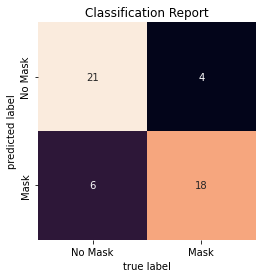

In [28]:
# Fit the model using SVC

sv_model = SVC(kernel='rbf', class_weight='balanced') # 'rbf' radial basis function

%time confusion_matrix_score(sv_model)


### <a id="dt" ></a> Build Decision Tree Classifier



Accuracy_score: 0.9183673469387755
classification_report: 
              precision    recall  f1-score   support

     No Mask       0.86      1.00      0.93        25
        Mask       1.00      0.83      0.91        24

    accuracy                           0.92        49
   macro avg       0.93      0.92      0.92        49
weighted avg       0.93      0.92      0.92        49


CPU times: total: 828 ms
Wall time: 825 ms


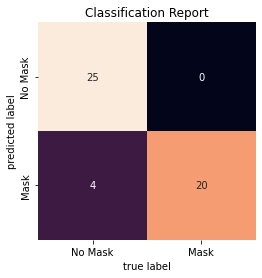

In [29]:
dt_model = tree.DecisionTreeClassifier()

%time confusion_matrix_score(model=dt_model)


### <a id="rf" ></a> Build Random Forest Classifier



Accuracy_score: 0.9387755102040817
classification_report: 
              precision    recall  f1-score   support

     No Mask       0.89      1.00      0.94        25
        Mask       1.00      0.88      0.93        24

    accuracy                           0.94        49
   macro avg       0.95      0.94      0.94        49
weighted avg       0.95      0.94      0.94        49


CPU times: total: 406 ms
Wall time: 408 ms


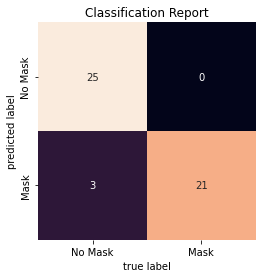

In [30]:
from sklearn import ensemble

rf_model = ensemble.RandomForestClassifier()

%time confusion_matrix_score(model=rf_model)


### <a id="nb" ></a> Build Naive Bayes Classifier



Accuracy_score: 0.7959183673469388
classification_report: 
              precision    recall  f1-score   support

     No Mask       0.80      0.80      0.80        25
        Mask       0.79      0.79      0.79        24

    accuracy                           0.80        49
   macro avg       0.80      0.80      0.80        49
weighted avg       0.80      0.80      0.80        49




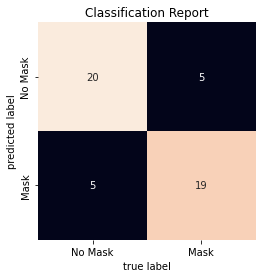

In [31]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

confusion_matrix_score(model=nb_model)

### <a id="lr" ></a> Logistic regression Classifier



CPU times: total: 0 ns
Wall time: 0 ns

Accuracy_score: 0.8571428571428571
classification_report: 
              precision    recall  f1-score   support

     No Mask       0.82      0.92      0.87        25
        Mask       0.90      0.79      0.84        24

    accuracy                           0.86        49
   macro avg       0.86      0.86      0.86        49
weighted avg       0.86      0.86      0.86        49




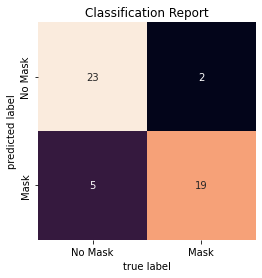

In [32]:
from sklearn.linear_model import LogisticRegression

%time lr_model = LogisticRegression()

confusion_matrix_score(lr_model)

### <a id="knn" ></a> K-Nearest Neighbors



CPU times: total: 0 ns
Wall time: 0 ns

Accuracy_score: 0.6938775510204082
classification_report: 
              precision    recall  f1-score   support

     No Mask       0.68      0.76      0.72        25
        Mask       0.71      0.62      0.67        24

    accuracy                           0.69        49
   macro avg       0.70      0.69      0.69        49
weighted avg       0.70      0.69      0.69        49




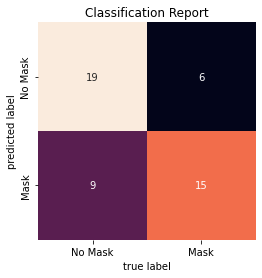

In [33]:
from sklearn.neighbors import KNeighborsClassifier

%time knn_model = KNeighborsClassifier() # n_neighbors=5 by default

confusion_matrix_score(knn_model)


### Load another dataset

In [34]:
# Load another folder to test and see

blurred_photos_folder = r".\AI LAB Workplace Monitoring\Face Mask Dataset\Blur Dataset\Test"

clear_photos_folder = r".\AI LAB Workplace Monitoring\Face Mask Dataset\Clear Datasets\val"

mask_test, no_mask_test = readFolderData(clear_photos_folder) # image form
test_data, label_data = preprocessEntireImageFolders(mask_test, no_mask_test) #reshaped form of (1, n)

comb = np.r_[no_mask_test, mask_test]
print( comb.shape, test_data.shape, label_data.shape )


(71, 30000) (71, 30000)
(142,) (142, 30000) (142,)


C:\Users\Utente locale\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\Utente locale\anaconda3\lib\site-packages\numpy\lib\index_tricks.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newobj = array(item, copy=False, subok=True, ndmin=ndmin)


### All models in a list

In [35]:
models = [sv_model, dt_model, rf_model, nb_model, lr_model, knn_model]

### <a id="loadfromdisk"></a> Load from disk. Here I use face-recognition module


In [49]:

def loadFromDisk(model, retry_if_not_sent=False):
    try:
        for i in range(len(comb)):# -1,-1,-1): #I wanna first start with mask, so I reverse
            
            frame = comb[i]
            frame = cv2.resize(frame, (900,700))
            face_locations = face_recognition.face_locations(frame)

            pred = model.predict( np.reshape( test_data[i], (1,-1)) )[0]
            if pred == 0:
                subject = "Worker not wearing a mask; Date {}, Time: {}"
                contents = "There is high probability that a worker is not wearing a mask. Take action!"
                name = "No Mask"
                color = (0,0,255)    
            else:
                name = "Mask"
                color = (255,0,0)
            
            for top, right, bottom, left in face_locations:                        
                cv2.rectangle(frame, (left, top), (right, bottom), color, 5)
                cv2.putText(frame, f"{name} & pred = {pred}", (left+10, bottom+30), cv2.FONT_HERSHEY_COMPLEX, 1, color, 2)

            if not face_locations:
                text = f"{name} & pred={pred}\nbut face not detected by face detector"
                left, top = 50, 50
                for i, line in enumerate(text.split('\n')):
                    y = (i+1)*top
                    cv2.putText(frame, line, (left,y), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                    
            #-------------------------------------------------------------------------
            #If covid19 distance rule is not respected, then send an alert
            violate = checkDistance(face_locations) if len(face_locations) >= 2 else False
            if violate:
                subject = "Violating covid19 distance rules; Date {}, Time: {}"
                contents = "mr. {} seems to be violating covid19 distance rules"
            
            #Send an alert if a worker is not wearing a mask or is violating covid19 distance rules
            if violate or not pred:
                date, time = date_and_time()
                sent = sendEmailWithAttachment(frame, 
                                            subject=subject.format(date, time),
                                            sender_password=sender_password,
                                            contents=contents)
                
                # Retry to send the the alert if it failed
                if retry_if_not_sent and not sent: resendIt(frame, sent)
            #------------------------------------------------------------------------------
            
            cv2.imshow("frame", frame)            
            if cv2.waitKey(1000) != -1: break
            
    finally:
        cv2.destroyAllWindows()   
    
def resendIt(frame, sent):
    if sent:
        return 
    else:
        sender_password = input("Retry the Password")
        sent = sendEmailWithAttachment(frame, sender_password = sender_password)
        return resendIt(frame, sent)
        
loadFromDisk(rf_model)


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10



### <a id="webcam"></a> Webcam Mask Detection


In [50]:

def openWebcam(model, retry_if_not_sent=False):
    #initialization for social distancing check
    unidentifiedNumPrev = 0
    namesViolPrev = set()
    dateTimeLastSent = datetime.now()
    
    cap = cv2.VideoCapture(0)
    try:
        while cap.isOpened():
            
            _, frame = cap.read()
            img = cv2.resize(frame, scale)
            pred = model.predict( np.reshape( img, (1,-1)) )[0]
            if pred == 0:
                subject = "Worker not wearing a mask; Date {}, Time: {}"
                contents = "{}There is high probability that a worker is not wearing a mask. Take action!"
                name = "No Mask"
                color = (0,0,255)       
            else:
                name = "Mask"
                color = (255,0,0)
                
            face_locations = face_recognition.face_locations(frame)
            #------------------------------------------------------------------
            #If covid19 distance rule is not respected, then send an alert
            
            violate, namesViolPrev, unidentifiedNumPrev = checkDistance(frame, face_locations, namesViolPrev, unidentifiedNumPrev, dateTimeLastSent)
            
            if violate:
                subject = "Violating covid19 distance rules; Date {}, Time: {}"
                contents = "mr. {} seems to be violating covid19 distance rules"
                
                if pred == 0:
                    subject = "Worker not wearing a mask and Violating covid19 distance rule; Date {}, Time: {}"
                    contents = "{} violating covid19 distance rules and not wearing mask"
            
            #Send an alert if worker is not wearing a mask or is violating covid19 distance rules
            if violate or not pred:
                date, time = date_and_time()
                sent = sendEmailWithAttachment(frame, 
                                            subject=subject.format(date, time),
                                            receiver_mail_addr = ["youremail@gmail.com"],
                                            sender_password=sender_password,
                                            contents=contents.format(namesViolPrev))
                
                # Retry to send the the alert if it failed
                if retry_if_not_sent and not sent: resendIt(frame, sent)
                
                dateTimeLastSent = datetime.now()
            #------------------------------------------------------------------------------
            
            for top, right, bottom, left in face_locations:                        
                cv2.rectangle(frame, (left, top), (right, bottom), color, 5)
                cv2.putText(frame, f"{name} & pred = {pred}", (left+10, bottom+30), cv2.FONT_HERSHEY_COMPLEX, 1, color, 2)

            if not face_locations:
                text = f"{name} & pred={pred}\nbut face not detected by face detector"
                left, top = 50, 50
                for i, line in enumerate(text.split('\n')):
                    y = (i+1)*top
                    cv2.putText(frame, line, (left,y), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            
            cv2.imshow("frame", frame)
            if cv2.waitKey(1) != -1: break

    finally:
        cap.release() 
        cv2.destroyAllWindows()   

openWebcam(sv_model)


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10


Email sent successfuly Date: 2022-06-20 Time: 10:37:10

